# Division Sigma 2020 Ignition Hacks
Authors: Rohit Ganti, Baladithya Balamurugan

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import round
import re
from sklearn import metrics
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import time
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
from tensorflow.keras.layers import Input, Dense, Activation, Lambda # only use these layers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import * # you can use any optimizer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
!rm contestant_judgment.csv 
!wget https://raw.githubusercontent.com/Codeseys/IgnitionHacks2020DivSigma/master/contestant_judgment.csv 
!rm training_data.csv 
!wget https://raw.githubusercontent.com/Codeseys/IgnitionHacks2020DivSigma/master/training_data.csv

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
--2020-08-31 22:59:21--  https://raw.githubusercontent.com/Codeseys/IgnitionHacks2020DivSigma/master/contestant_judgment.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 56472148 (54M) [text/plain]
Saving to: ‘contestant_judgment.csv’

c

In [2]:
df_train = pd.read_csv('training_data.csv')
df_train.head()

,ID,User,Text,Sentiment
0,864192,Carly_FTS,I *heart* filling up @dennisschaub desk 1 it...,1
1,523691,Open_Sourcing,"#SocioMat - people create prettier, younger an...",1
2,584154,xxcharlx,no way i dont want the tour to end,0
3,1527961,andreapuddu,@HemalRadia Hi Amazing Brother! Sending Limitl...,1
4,28609,umbec,@flockmaster they are chocolate,1


In [3]:
stopwordslist =  set(stopwords.words('english'))
lemmatty = WordNetLemmatizer()
wordnetmap = {"N":wordnet.NOUN, "V":wordnet.VERB, "J":wordnet.ADJ, "R":wordnet.ADV}
def removestopwords(text):    
    return " ".join([word for word in str(text).split() if word not in stopwordslist])
def lemmy(text):
    pos_text = nltk.pos_tag(str(text).split())
    return " ".join([lemmatty.lemmatize(word,wordnetmap.get(pos[0],wordnet.NOUN))for word, pos in pos_text])    

def clean_text(text):
    text = re.sub(r'@[A-Za-z0-9]+','',text)
    text = re.sub(r'#','',text)
    
    text = re.sub(r'RT[\s]+','',text)
    text = re.sub(r'https?:\/\/\S+','',text)
    
    text = lemmy(text)
    text = text.lower()
    text = re.sub(r'[^\w\s]','', text)
    text = removestopwords(text)
    
    return text

# df_train['Text']=df_train['Text'].apply(clean_text)
# df_train.head()

In [4]:
TextBlob(df_train['Text'][1]).words

WordList(['SocioMat', 'people', 'create', 'prettier', 'younger', 'and', 'better', 'looking', 'avatars', 'of', 'themselves'])

In [5]:
def vectorizer(data):

  start = time.time()

  tfidf = TfidfVectorizer(analyzer=clean_text,max_features=650)
  tfidfvect = tfidf.fit_transform(data)

  end = time.time()
  hours, rem = divmod(end-start, 3600)
  minutes, seconds = divmod(rem, 60)
  print("--- {:0>2}:{:0>2}:{:05.2f} ---".format(int(hours),int(minutes),seconds))

  print(tfidfvect.shape)
  return pd.DataFrame(tfidfvect.toarray(),columns=tfidf.get_feature_names())

x_tfidf=vectorizer(df_train['Text'])
# x_test_tfidf=vectorizer(x_test)

--- 00:13:44.08 ---
(1000000, 650)


In [6]:
x_tfidf['Length']=df_train['Text'].apply(lambda row: len(row))
x_tfidf.shape

(1000000, 651)

In [7]:
def binAct(x):
  return tf.round(x)
# binAct(0.35)

In [8]:
input_layer = Input(shape=(651))
x=Dense(units=200,activation='relu')(input_layer)
x=Dense(units=200,activation='relu')(x)
x=Dense(units=1,activation='sigmoid')(x)
# x=Dense(units=1,activation=binAct)(x)
# x=Lambda(binAct)(x)
model = Model(input_layer,(x))
# model = Sequential()
# model.add(Input(shape=(651)))
# model.add(Dense(units=200,activation='tanh'))
# model.add(Dense(units=200,activation='tanh'))
# model.add(Dense(units=1,activation='sigmoid'))
# model.add(Dense(units=1,activation=binAct))

In [9]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 651)]             0         
_________________________________________________________________
dense (Dense)                (None, 200)               130400    
_________________________________________________________________
dense_1 (Dense)              (None, 200)               40200     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 201       
Total params: 170,801
Trainable params: 170,801
Non-trainable params: 0
_________________________________________________________________


In [10]:
optimizer = Adam()
model.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy'])

In [11]:
hist = model.fit(x_tfidf, df_train['Sentiment'], epochs=20, validation_split=0.2)

Epoch 1/20
25000/25000 [==============================] - 75s 3ms/step - loss: 0.6757 - accuracy: 0.5692 - val_loss: 0.6699 - val_accuracy: 0.5754
Epoch 2/20
25000/25000 [==============================] - 69s 3ms/step - loss: 0.6620 - accuracy: 0.5902 - val_loss: 0.6609 - val_accuracy: 0.5879
Epoch 3/20
25000/25000 [==============================] - 68s 3ms/step - loss: 0.6573 - accuracy: 0.5972 - val_loss: 0.6577 - val_accuracy: 0.5941
Epoch 4/20
25000/25000 [==============================] - 68s 3ms/step - loss: 0.6545 - accuracy: 0.5993 - val_loss: 0.6550 - val_accuracy: 0.6012
Epoch 5/20
25000/25000 [==============================] - 70s 3ms/step - loss: 0.6520 - accuracy: 0.6029 - val_loss: 0.6517 - val_accuracy: 0.6056
Epoch 6/20
25000/25000 [==============================] - 68s 3ms/step - loss: 0.6502 - accuracy: 0.6057 - val_loss: 0.6492 - val_accuracy: 0.6100
Epoch 7/20
25000/25000 [==============================] - 69s 3ms/step - loss: 0.6486 - accuracy: 0.6075 - val_loss: 0

In [12]:
def plot_losses(hist):
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'])
    plt.show()
def plot_accuracies(hist):
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'])
    plt.show()

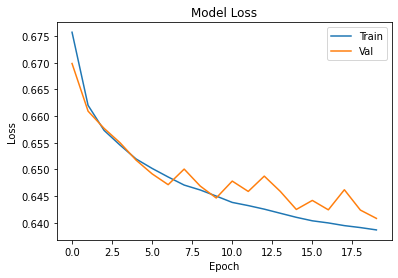

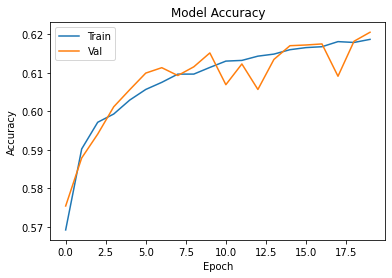

In [13]:
plot_losses(hist)
plot_accuracies(hist)

In [14]:
!mkdir -p models
tf.keras.models.save_model(model,'models/divsigma',overwrite=True,include_optimizer=True,save_format=None,signatures=None,options=None)
!ls -l models/

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: models/divsigma/assets
total 4
drwxr-xr-x 4 root root 4096 Aug 31 23:38 divsigma


In [15]:
divsigma = tf.keras.models.load_model('models/divsigma')

In [16]:
judge = pd.read_csv('contestant_judgment.csv')
judge_tfidf=vectorizer(judge['Text'])

--- 00:08:21.61 ---
(599999, 650)


In [17]:
judge_tfidf['Length']=judge['Text'].apply(lambda row: len(row))
judge_tfidf.shape

(599999, 651)

In [18]:
judge_predict = divsigma.predict(judge_tfidf)

In [19]:
ndf = pd.DataFrame(judge_predict, columns=['Sentiment'])
print(ndf.head())

   Sentiment
0   0.441720
1   0.571121
2   0.274766
3   0.513551
4   0.526040


In [20]:
ndf['Sentiment'] = ndf['Sentiment'].apply(lambda row: 1 if row>=0.5 else 0)
print(ndf.head())
judgefinal = pd.concat([judge,ndf],axis=1)
print(judgefinal.head())

   Sentiment
0          0
1          1
2          0
3          1
4          1
       ID  ... Sentiment
0  599303  ...         0
1  359673  ...         1
2  391095  ...         0
3  820049  ...         1
4  658429  ...         1

[5 rows x 4 columns]


In [21]:
judgefinal.to_csv('Sadness_RohitGanti_BaladithyaBalamurugan.csv')

In [22]:
# cvec= TfidfVectorizer( analyzer='word', stop_words= 'english', max_features=7500, lowercase= True)
# documents= df['Text'].values.astype('U')
# X= cvec.fit_transform(documents).toarray()
# words= cvec.get_feature_names()
# y=df['Sentiment']
# X_train, X_test, y_train, y_test= train_test_split(X,y, test_size=0.2, shuffle= True)

# start= timer();

# logreg= LogisticRegression(max_iter=500)
# logreg.fit(X_train, y_train)

# y_pred= logreg.predict(X_test)
# result= classification_report(y_test, y_pred)
# print(result)
# end= timer();


# score= logisticReg.score(X_test, y_test)
# print("Score of our model is: " +str(score))
# print("Time for the model is: " +str(end-start))


In [23]:
# # df_train.to_csv('newcsvtest.csv')
# SEED=114
# x = x_tfidf
# y = df_train['Sentiment']

# x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=SEED)

# print("xTrain:",x_train.shape,"yTrain:",y_train.shape)
# print("xTest:",x_test.shape,"yTest:",y_test.shape)

In [24]:
# print(x_train.head())
# print(x_test.head())
# print(y_train.head())
# print(y_test.head())

In [25]:
# start = time.time()
# logreg = LogisticRegression(max_iter=500,solver='sag',random_state=SEED,C=1).fit(x_train.astype('float64'),y_train)
# end = time.time()
# hours, rem = divmod(end-start, 3600)
# minutes, seconds = divmod(rem, 60)
# print("--- {:0>2}:{:0>2}:{:05.2f} ---".format(int(hours),int(minutes),seconds))

# y_pred = logreg.predict(x_test)
# result = classification_report(y_test,y_pred)
# print(result)
# score= logisticReg.score(X_test, y_test)
# print("Score of our model is: " +str(score))